In [1]:
import pandas as pd
import numpy as np
import Utils
import tensorflow as tf
import keras
import pickle
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.utils import class_weight
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from gensim.models import Word2Vec
from gensim.models.keyedvectors import KeyedVectors

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import Concatenate
from keras.layers import Dense, Input, GlobalMaxPooling1D, GlobalAveragePooling1D, Flatten, Dropout
from keras.layers import LSTM, Bidirectional, Embedding, Reshape
from keras.layers.merge import Concatenate
from keras.models import Model, load_model
from keras.utils import to_categorical, plot_model
from keras.backend.tensorflow_backend import set_session

# import nltk
# nltk.download('stopwords')

from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
import unicodedata
import re
import gc

import Utils.data_utils as data
import Utils.metric_utils as mtric

Using TensorFlow backend.


In [2]:
gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
#%time data_x, data_y = load_data('dataset/Raw/Train.tsv', [1, 3, 4], True, 1)
MAX_NB_WORDS = 30000
EMBEDDING_DIM = 150
MAX_SEQUENCE_LENGTH = 250

path_train = 'dataset/Processed/Train_lemma_coma_blind_num.pickle'
path_test = 'dataset/Processed/Test_lemma_coma_blind_num.pickle'
path_w2v = 'w2v/pharmacovigilance_twitter_w2v.txt' # http://evexdb.org/pmresources/vec-space-models/

tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
dataset = data.Dataset()

dataset.load_pickle(path_train, path_test, label_name='rating')
model = KeyedVectors.load_word2vec_format(path_w2v)
#MAX_SEQUENCE_LENGTH = dataset.text_len_distribution(col_name='review', plot=False)[0]

In [4]:
# dataset.replace(parse_col_name='review', old='#', new='$number')

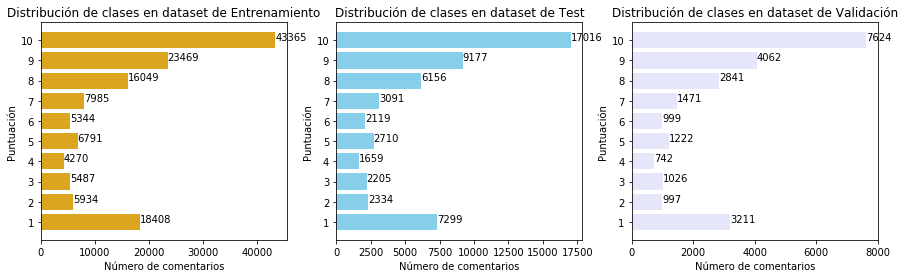

In [5]:
tokenizer.fit_on_texts([x for x in list(dataset.get_train_x().review)+list(dataset.get_test_x().review)])
dataset.make_dev_split(dev_split=0.15)
dataset.classes_distribution()

In [6]:
sequences_train = tokenizer.texts_to_sequences(dataset.get_train_x().review)
sequences_dev = tokenizer.texts_to_sequences(dataset.get_dev_x().review)
sequences_test = tokenizer.texts_to_sequences(dataset.get_test_x().review)

Xtrain = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='pre')
Xdev = pad_sequences(sequences_dev, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='pre')
Xtest = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='pre')
ytrain = to_categorical(dataset.get_train_y()-dataset.get_train_y().min())
ydev = to_categorical(dataset.get_dev_y()-dataset.get_dev_y().min())
ytest = to_categorical(dataset.get_test_y()-dataset.get_test_y().min())

del sequences_dev, sequences_train, sequences_test
gc.collect()

0

In [7]:
word_index = tokenizer.word_index
num_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM), dtype=np.float32)
count = 0
for word, i in word_index.items():
    if i >= num_words:
        continue
    if word in model:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = model[word]
        count = count+1
print (count," ",num_words) #26649

12161   30000


In [8]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

# class_W = class_weight.compute_class_weight('balanced', np.unique(np.asarray(df_train.label)), np.asarray(df_train.label))
# class_weight_dict = dict(enumerate(class_W))

class Metrics(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.f1s = 0
    def on_epoch_end(self, batch, logs={}):
        predict = np.asarray(self.model.predict(self.validation_data[0])).argmax(axis=1)
        targ = self.validation_data[1].argmax(axis=1)
        #f1 = f1_score(targ, predict, average='micro')
        mtrcs = precision_recall_fscore_support(targ, predict, average='macro')
        print ("\nPrecision: "+str(mtrcs[0])+"\tRecall: "+str(mtrcs[1])+"\tF1: "+str(mtrcs[2]))
        if (self.f1s < mtrcs[2]):
            self.f1s = mtrcs[2]
            self.model.save('./model/LSTM_static_twitter_Best_EMRS_model_f1_.hdf5')
            print("Modelo guardado\n")
        return
    
metrics = Metrics()

In [9]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,))

embedded_sequences = embedding_layer(sequence_input)
drop_out_1 = Dropout(0.3, name='drop_out_1')(embedded_sequences)

biLSTM_1 = Bidirectional(LSTM(250))(drop_out_1)

drop_out_2 = Dropout(0.3, name='drop_out_2')(biLSTM_1)
mp_dense = Dense(128, activation='relu', name='mp_dense')(drop_out_2)
preds = Dense(10, activation='softmax', name='preds')(mp_dense)
biLSTM_model = Model(sequence_input, preds)

biLSTM_model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

callbacks_list = [metrics]

In [1]:
#200 epochs -> start at 13:35 - ends at XX:XX
biLSTM_model.fit(Xtrain, ytrain,
      #class_weight=class_weight_dict,
      shuffle=True,
      batch_size=200,
      epochs=200,
      callbacks=callbacks_list,
      validation_data=(Xdev, ydev))

In [11]:
LSTM_Best_model = load_model('./model/LSTM_static_twitter_Best_EMRS_model_f1_.hdf5')
y_test = ytest.argmax(axis=1)

In [2]:
# result = Best_model.predict(Xtest).argmax(axis=1)
result = biLSTM_model.predict(Xtest).argmax(axis=-1)
print(classification_report(y_test, result, digits=4))
#print(confusion_matrix(y_test, result)) #y -> real; x -> predict

In [3]:
result2 = LSTM_Best_model.predict(Xtest).argmax(axis=1)
print(classification_report(y_test, result2, digits=4))
#print(confusion_matrix(y_test, result)) #y -> real; x -> predict

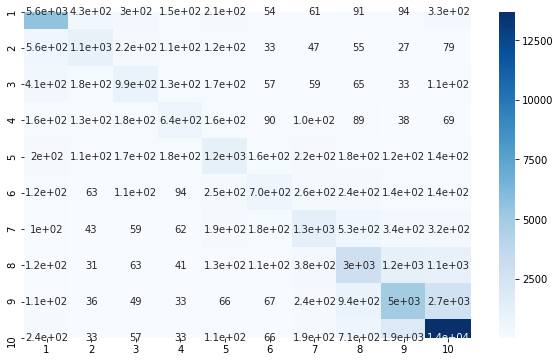

In [14]:
data.matrix_printer(confusion_matrix(y_test, result2), [1,2,3,4,5,6,7,8,9,10], [1,2,3,4,5,6,7,8,9,10]).show()

In [15]:
biLSTM_model.save('./model/LSTM_static_twitter_200epoch_EMRS_model_f1_.hdf5')